## Upload dataset

In [2]:
# !kaggle competitions download -c house-prices-advanced-regression-techniques

## Import libraries

In [49]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import statsmodels.api as sm
from scipy.stats import norm
from scipy import stats
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

plt.rcParams['figure.dpi'] = 100
plt.style.use('fast')

## Load train dataframe

In [14]:
data_train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
train = pd.DataFrame(data_train)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Load test dataframe

In [15]:
data_test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
test = pd.DataFrame(data_test)
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (1460, 81)
test shape: (1459, 80)


## Merge train and test dataframes to full

In [6]:
full = pd.concat([train, test])

## Analyze target distribution

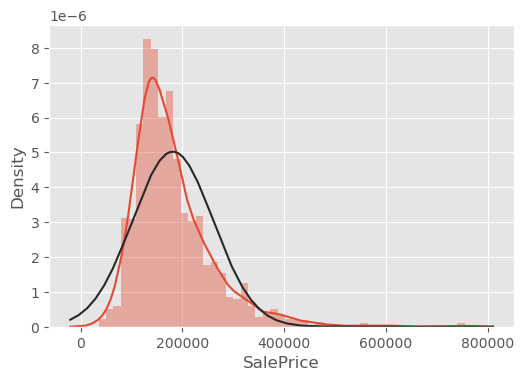

In [50]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
# fig, ax = plt.subplot(1,2, figsize= (15,5))
# sm.qqplot(full.SalePrice, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
    sns.distplot(full.SalePrice, kde = True, hist=True, fit = norm);
# plt.show()


## Change empty SalePrice values to predicted

In [ ]:
full['SalePrice'].iloc[1460:] = sales_predicted_test['SalePrice']

## Delete columns that dont need

In [38]:
full.drop(['Id'],axis =1,inplace=True)
full.drop(['Utilities'],axis =1,inplace=True)
full.drop(['BedroomAbvGr'],axis =1,inplace=True)
full.drop(['KitchenAbvGr'],axis =1,inplace=True)

## Get all categorical features

In [39]:
cat_features = full.select_dtypes(include=['object']).columns.tolist()

## Append categorial features that have numerical values

In [40]:
cat_features.append('MSSubClass')
cat_features.append('OverallQual')
cat_features.append('OverallCond')
cat_features.append('YearRemodAdd')
cat_features.append('GarageYrBlt')
cat_features.append('GarageCars')
cat_features.append('MoSold')
cat_features.append('YrSold')
# cat_features

## Get all numeric features

In [41]:
num_features = full.select_dtypes(exclude=['object']).columns.tolist()

## Remove categorial features that have numerical values

In [42]:
num_features.remove('MSSubClass')
num_features.remove('OverallQual')
num_features.remove('OverallCond')
num_features.remove('YearRemodAdd')
num_features.remove('GarageYrBlt')
num_features.remove('GarageCars')
num_features.remove('MoSold')
num_features.remove('YrSold')
num_features.remove('YearBuilt')
# num_features

## Convert YearBuilt to Years (how old house is)

In [43]:
full.rename(columns={"YearBuilt": "Years"}, inplace=True)
full['Years'] = 2017 - full['Years']

num_features.append('Years')

In [44]:
full.isnull().values.sum()

13963

## Replace all nan elements to median in numerical features

In [45]:
full[num_features] = full[num_features].fillna(full[num_features].median())

print("Remaining NAs for numerical features in train : " + str(full[num_features].isnull().values.sum()))

Remaining NAs for numerical features in train : 0


In [46]:
full.isnull().values.sum()

13445

## Get all features with non normal distributions in numerical features

### Check non normal numeric values by Shapiro-Wilk test.

In [47]:
from scipy.stats import skew s
import scipy.stats as stats
from scipy.stats import shapiro

skewness = full[num_features].apply(lambda x: stats.shapiro(x.fillna(0))[1] < 0.01)
skewness.sort_values(ascending=False)

skewness = skewness[abs(skewness)>0.5]

skew_features = full[skewness.index]
# skew_features.columns
# skew_features

## Treat skewness features with log transformation

In [48]:
full[skew_features.columns] = np.log1p(full[skew_features.columns])
# full[skew_features.columns]

## Replace all NaN elements in categorial features

In [49]:
full[cat_features] = full[cat_features].fillna('No')

## Apply target encoding for categorical features

In [50]:
from category_encoders import TargetEncoder

for cat in cat_features:
    encoder = TargetEncoder()
    full[cat] = encoder.fit_transform(full[cat], full['SalePrice'])

## Import models

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

## Use full dataframe for training model. And get test df for get predictions to upload to kaggle.

In [52]:
train = full
test = full.iloc[1460:]

## Remove SalePrice from train and test df's

In [53]:
train = train.drop(['SalePrice'], axis=1)
test = test.drop(['SalePrice'], axis=1)

## Get target values and set it to y

In [54]:
y = full['SalePrice']

## Split train to X_train and X_test for check models errors

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state= 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2043, 76), (876, 76), (2043,), (876,))

## Init models and its parameters

In [56]:
# Parameters
alphas_alt = [0.5742104667328154]
alphas2 = [1.879091248501181e-05]
e_alphas = [0.00019646888384623228]
e_l1ratio = [0.00010169670649057203]


In [61]:
# Models

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 29.501807621257495, epsilon= 1.2121198952947593e-05, gamma=0.15570361630184554))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr),
                                meta_regressor=gbr,
                                use_features_in_secondary=True)

## Train models

In [62]:
stack_gen_model = stack_gen.fit(train, y)

In [63]:
elastic_model_full_data = elasticnet.fit(train, y)

In [64]:
lasso_model_full_data = lasso.fit(train, y)

In [65]:
ridge_model_full_data = ridge.fit(train, y)

In [66]:
svr_model_full_data = svr.fit(train, y)

In [67]:
gbr_model_full_data = gbr.fit(train, y)

## Test Optuna

In [848]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
p_from = 0.0001
p_to = 1

# с_from = 0.1
# с_to = 40

g_from = 1
g_samples_split_from = 2
g_to = 16


# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    
#     alphas = trial.suggest_float('alpha', p_from, p_to, log=True)
#     l1_ratio = trial.suggest_float('l1_ratio', p_from, p_to, log=True)
    
#     С = trial.suggest_float('С', с_from, с_to, log=True)
#     epsilon = trial.suggest_float('epsilon', p_from, p_to, log=True)
#     gamma = trial.suggest_float('gamma', p_from, p_to, log=True)
    
    learning_rate = trial.suggest_float('learning_rate', p_from, p_to, log=True)
    max_depth = trial.suggest_int('max_depth', g_from, g_to, log=True)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', g_from, g_to, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', g_samples_split_from, g_to, log=True)
    
    # Models
    
#     regr_obj = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas))
#     regr_obj = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=[alphas], random_state=42))
#     regr_obj = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=[alphas], l1_ratio=[l1_ratio]))
#     regr_obj = make_pipeline(RobustScaler(), SVR(C= С, epsilon= epsilon, gamma= gamma))
    regr_obj = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, max_depth=max_depth, max_features='sqrt', min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, loss='huber', random_state =42)  
    
    regr_obj_data = regr_obj.fit(train, y)
    
    pred = regr_obj_data.predict(X_test)
    
    error = mean_squared_error(pred, y_test)
    
    return error

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, show_progress_bar=True)
study.best_params

  0%|          | 0/500 [00:00<?, ?it/s]

## Blend all models

In [99]:
def blend_models_predict(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.6 * stack_gen_model.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.05 * elastic_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)))

pred = blend_models_predict(X_test)

print("test MSE:", mean_squared_error(pred, y_test))

test MSE: 0.0028728486638769056


## Get final predictions for test data

In [96]:
final_test_pre = blend_models_predict(test)
normal_prices_arr = np.expm1(final_test_pre)

n_prices_df = pd.DataFrame(normal_prices_arr.tolist(), columns=['SalePrice'], index=range(1461, 2920)).rename_axis('Id')
n_prices_df

,SalePrice
Id,
1461,115960.237478
1462,158798.516874
1463,181169.842729
1464,195348.653360
1465,196654.944730
...,...
2915,81598.693999
2916,83878.743125
2917,158834.310057


## Export the submission.scv

In [97]:
# n_prices_df.to_csv('submission_blend-rcv_gbr.csv')
n_prices_df.to_csv('submission.csv')

## Upload to kaggle

In [98]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "21.10.21 -- 1"

100%|██████████████████████████████████████| 33.7k/33.7k [00:06<00:00, 5.49kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques